
Getting Started
============

The **KXY platform** is the _only AutoML platform_ dedicated to bringing about **business value** by addressing two classes of questions that are fundamental to the data science life cycle in a rigorous, fast, and cost-effective manner:

* **Pre-Learning Questions**: How valuable is a dataset for improving decision making, in an absolute sense and relative to others?
* **Post-Learning Questions**: How do you explain what your trained model is doing, including ensuring it is not biased? Which action would yield a higher ROI, trying to improve your trained model using the same datasets, or investing in acquiring additional and complementary datasets?


Installation
-------------

The KXY python package can be installed from PyPi by running

``pip install kxy``

The package only supports python 3.


Authentication
-----------------

All heavy-duty operations, including but not limited to solving any **maximum-entropy optimization problem**, are run on the KXY infrastructure and require an API key. The API key should be set in the environment variable ``KXY_API_KEY``. 

This can be done in MacOS or Linux terminals by running 

``export KXY_API_KEY='YOUR API KEY GOES HERE'``

or from within your python program by running 

In [1]:
import os
# os.environ['KXY_API_KEY'] = 'YOUR API KEY GOES HERE'

Toy Examples
----------------

### Classification

#### Loading Data

In [2]:
import pandas as pd
# It is crucial to import the kxy package to access our methods
# from all pandas DataFrame instances.
import kxy 
# Bank note UCI dataset (binary classification)
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/'\
	'data_banknote_authentication.txt'
df = pd.read_csv(url, names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Is Fake'])

#### Problem Feasibility

To what extent can we predict whether the bank note is fake from an image using provided 
inputs (irrespective of the classification model)?

In [3]:
'Classification Feasibility: %.4f nats' % df.kxy.classification_feasibility('Is Fake')

'Classification Feasibility: 2.3410 nats'

The higher the feasibility score is relative to the entropy of the response, the better. A value of 0
means no model can successfully solve this classification problem using provided inputs, no
matter how complex, no matter how deep. In such as a case, resources should be allocated to 
looking for more relevant datasets to use as inputs, rather than increasing model complexity.

In [4]:
'Label Shannon Entropy: %.4f nats' % kxy.discrete_entropy(df['Is Fake'].values)

'Label Shannon Entropy: 0.6870 nats'

#### Input Importance

Once we know the problem is feasible using inputs at hand, the next question before we jump
into modeling is what are the inputs that are the most useful for solving this problem. Once
more, this question is asked and answered independently from any classification model (this is a **pre-learning** problem), and reduces time wasted improving models fitted on irrelevant inputs.

First, we determine how useful each input is, in isolation, for solving this classification problem.

In [5]:
importance_df_1 = df.kxy.individual_input_importance('Is Fake')
importance_df_1.rename(columns={\
        'input': 'Input', 'individual_importance': 'Individual Importance',\
        'normalized_individual_importance': 'Normalized Individual Importance',\
        'cum_normalized_individual_importance': \
                'Cum Normalized Individual Importance'}).round(2)\
        .set_index(['Input'])

,Individual Importance,Normalized Individual Importance,Cum Normalized Individual Importance
Input,,,
Variance,1.31,0.72,0.72
Skewness,0.42,0.23,0.95
Kurtosis,0.09,0.05,1.00
Entropy,0.00,0.00,1.00


The `Variance` input is found to be, by far, the most informative about the type of bank note, when inputs are used in isolation. The `Skewness` input comes second, and the other two add negligible value when used in isolation.

As useful as this observation is, it does not necessarily paint the full picture. Some inputs might be of little value when used in isolation, but act as a good complement when used in conjunction with other inputs. Others might be of great value when used in isolation, but end up being redundant when used in conjunction with other inputs.

To elucidate this, we determine the complementary value-add of each input. `df.kxy.incremental_input_importance` first selects the input with the highest importance when used in isolation, then sequentially selects, among all inputs that haven't yet been selected, the input with the highest complementary value-add (relative to all previously selected inputs).

In [6]:
importance_df_2 = df.kxy.incremental_input_importance('Is Fake')
importance_df_2.rename(columns={\
        'input': 'Input', 'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'selection_order': 'Selection Order',\
        'cum_normalized_incremental_importance': \
                'Cummulative Normalized Incremental Importance'}).round(2)\
        .set_index(['Input'])

,Selection Order,Incremental Importance,Normalized Incremental Importance,Cummulative Normalized Incremental Importance
Input,,,,
Variance,1,1.31,0.56,0.56
Skewness,2,0.46,0.19,0.75
Kurtosis,3,0.39,0.17,0.92
Entropy,4,0.18,0.08,1.00


Let's plot both types of input importance scores to ease visualization.

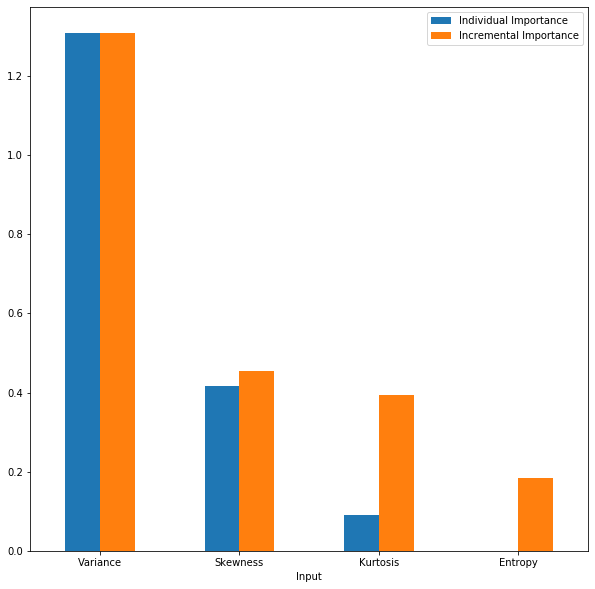

In [7]:
importance_df = pd.concat([importance_df_1.set_index(['input']),\
                           importance_df_2.set_index(['input'])], axis=1)
importance_df.reset_index(inplace=True)
importance_df = importance_df.rename(columns={'input': 'Input',\
    'individual_importance': 'Individual Importance', \
    'incremental_importance': 'Incremental Importance', \
    'selection_order': 'Selection Order'})
importance_df = importance_df[['Input', 'Individual Importance', \
    'Incremental Importance', 'Selection Order']]
importance_df = importance_df.sort_values(by=['Selection Order'],\
                                          ascending=True)
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
importance_df[['Input', 'Individual Importance', 'Incremental Importance']]\
    .plot.bar(x='Input', rot=0, ax=ax)
plt.show()

Interestingly, both `Kurtosis` and `Entropy` provide little value when used in isolation, but when used in conjunction `Variance` and `Skewness` they have the potential to prove very useful.

#### Basic Model Training

Let's dive in and train a basic linear classifier on our dataset.

In [8]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
# Training
train_df = df.iloc[:1000]
x_train = train_df[['Variance', 'Skewness', 'Kurtosis']].values 
y_train = train_df['Is Fake'].values
classifier = LogisticRegression(random_state=0).fit(x_train, y_train)

# Testing
test_df = df.iloc[1000:]
x_test =  test_df[['Variance', 'Skewness', 'Kurtosis']].values
y_test = test_df['Is Fake'].values

# Out-of-sample predictions
predictions = classifier.predict(x_test)
test_df['Prediction'] = predictions

# Out-of-sample accuracy in %
'Out-Of-Sample Accuracy: %.2f%%' % (100. * classifier.score(x_test, y_test))

'Out-Of-Sample Accuracy: 98.92%'

#### Suboptimality of Trained Model

As we train models, we are faced with the following dilemma on resource allocation: are we better off investing time and money trying to improve our existing model with a more complex model, or have we already gotten the most out of existing inputs, and we should instead invest in acquiring complementary and/or more informative inputs?

Back to our bank note example, a 1% classification error corresponds to letting 10 millions through per billion of forged currencies. If a billion of forge currencies would take less than 10 millions of geniune currency to make, then the classification error is not yet low enough to render forgery unprofitable. So what should we do to drop this classification error further? Can we do better using the same inputs and a nonlinear model? Or should we seek additional complementary inputs?

This is where the method `df.kxy.classification_suboptimality` comes in.

In [9]:
'Classifier Suboptimality: %.4f nats' % test_df.kxy.classification_suboptimality(\
    'Prediction', 'Is Fake')

'Classifier Suboptimality: 0.0000 nats'

As it turns out, a simple logistic regression allows us to extract nearly all of the intrinsic value there is in using the 3 inputs above to determmine whether a bank note is a forgery. Thus, trying out a nonlinear model might not yield the highest ROI. 

That a nonlinear model would not perform materially better than a linear model is consistent with the visualization below, where it can be seen that a curved boundary would not necessarily do a much better job at separating geniune (green) from fake (red) notes than a straight line.

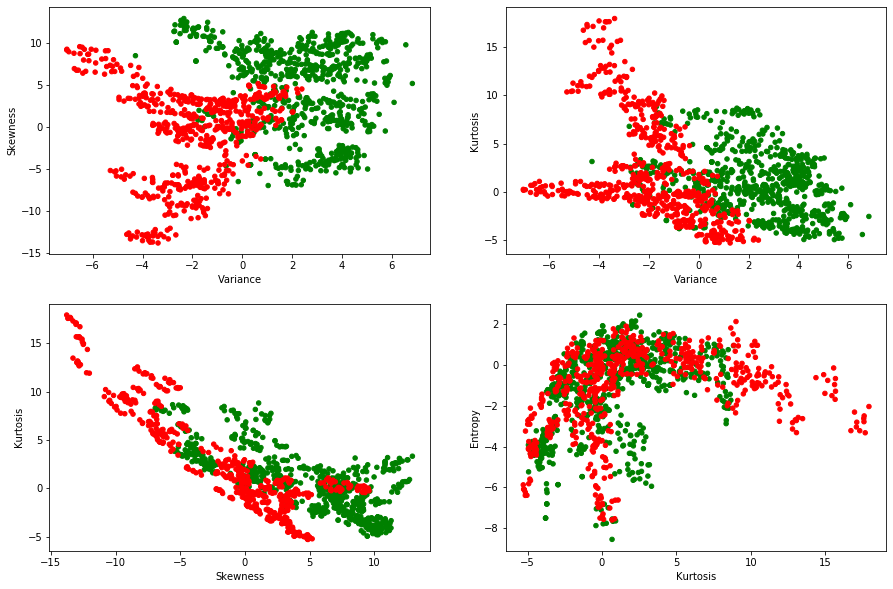

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df.plot.scatter(ax=ax[0, 0], x='Variance', y='Skewness', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[0, 1], x='Variance', y='Kurtosis', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 0], x='Skewness', y='Kurtosis', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 1], x='Kurtosis', y='Entropy',  c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
plt.show()

### Regression

Much of the analysis above can be extended to regression problems. We consider one such problem from the UCI machine learning repository below.

In [11]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'\
                 '00243/yacht_hydrodynamics.data', sep='[ ]{1,2}',\
                 names=['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number',\
                        'Residuary Resistance'])
df.rename(columns={col: col.title() for col in df.columns})

,Longitudinal Position,Prismatic Coeefficient,Length-Displacement,Beam-Draught Ratio,Length-Beam Ratio,Froude Number,Residuary Resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
...,...,...,...,...,...,...,...
303,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
304,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
305,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
306,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


#### Problem Feasibility

In [12]:
label_column = 'Residuary Resistance'
# Pre-Learning: How feasible or solvable is this problem? Are inputs any useful?
'Feasibility: %.4f nats, Entropy: %.4f nats' % (\
    df.kxy.regression_feasibility(label_column), \
    kxy.scalar_continuous_entropy(df[label_column].values))

'Feasibility: 3.3846 nats, Entropy: 3.6338 nats'

#### Input Importance

In [13]:
# Pre-Learning: How useful is each input individually?
importance_df_1 = df.kxy.individual_input_importance(label_column).rename(columns={\
        'input': 'Input', 'individual_importance': 'Individual Importance',\
        'normalized_individual_importance': 'Normalized Individual Importance',\
        'cum_normalized_individual_importance': 'Cum Normalized Individual Importance'})\
        .round(2).set_index(['Input'])
importance_df_1

,Individual Importance,Normalized Individual Importance,Cum Normalized Individual Importance
Input,,,
Froude Number,2.21,1.0,1.0
Length-Displacement,0.00,0.0,1.0
Longitudinal Position,0.00,0.0,1.0
Prismatic Coeefficient,0.00,0.0,1.0
Beam-Draught Ratio,0.00,0.0,1.0
Length-Beam Ratio,0.00,0.0,1.0


In [14]:
# Pre-Learning: How much value does each input add marginally?
importance_df_2 = df.kxy.incremental_input_importance(label_column).rename(columns={\
        'input': 'Input', 'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'selection_order': 'Selection Order', 'cum_normalized_incremental_importance': \
                'Cum Normalized Incremental Importance'}).round(2).set_index(['Input'])
importance_df_2

,Selection Order,Incremental Importance,Normalized Incremental Importance,Cum Normalized Incremental Importance
Input,,,,
Froude Number,1,2.21,0.78,0.78
Beam-Draught Ratio,2,0.13,0.05,0.83
Length-Displacement,3,0.12,0.04,0.88
Longitudinal Position,4,0.12,0.04,0.92
Prismatic Coeefficient,5,0.12,0.04,0.96
Length-Beam Ratio,6,0.11,0.04,1.00


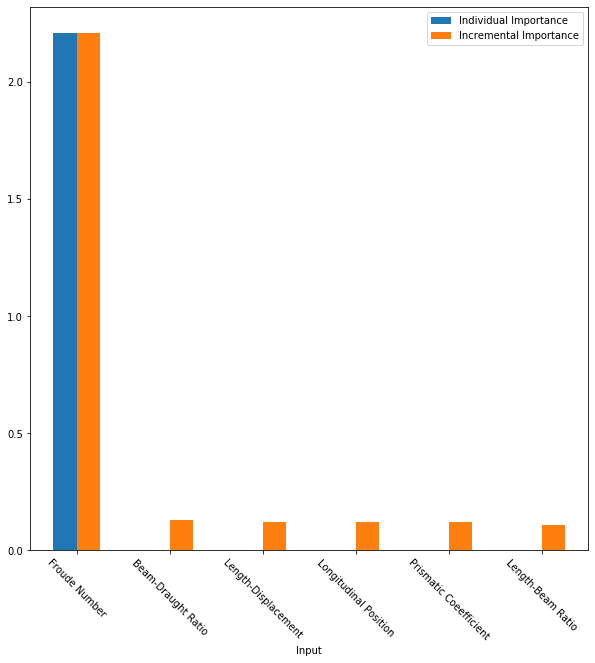

In [15]:
# Putting everything together in a plot
importance_df = pd.concat([importance_df_1, importance_df_2], axis=1)
importance_df.reset_index(inplace=True)
importance_df.rename(columns={'index': 'Input'}, inplace=True)
importance_df = importance_df[['Input', 'Individual Importance', \
    'Incremental Importance', 'Selection Order']]
importance_df = importance_df.sort_values(by=['Selection Order'],\
                                          ascending=True)
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
importance_df[['Input', 'Individual Importance', 'Incremental Importance']]\
    .plot.bar(x='Input', rot=-45, ax=ax)
plt.show()

#### Basic Model Training

In [16]:
# Learning (Basic Linear Regression)
from sklearn.linear_model import LinearRegression
# Training
train_size = 200
train_df = df.iloc[:train_size]
x_train = train_df[['Froude Number']].values
y_train = train_df[label_column].values
model = LinearRegression().fit(x_train, y_train)

# Testing
test_df = df.iloc[train_size:]
x_test = test_df[['Froude Number']].values
y_test = test_df[label_column].values

# Out-of-sample predictions
predictions = model.predict(x_test)
test_df['Prediction'] = predictions

# Out-of-sample accuracy (R^2)
'Out-Of-Sample R^2: %.2f' % (model.score(x_test, y_test))

'Out-Of-Sample R^2: 0.65'

#### Absolute Suboptimality of Trained Model

As in the case of classification models, we may quantify the extent to which the trained regression model can be improved without resorting to additional inputs, and without imposing any restriction on the model that could bring about said improvement.

In [17]:
'Suboptimality: %.4f nats' % \
    test_df.kxy.regression_suboptimality('Prediction', label_column)

'Suboptimality: 1.3197 nats'

#### Additive Suboptimality of Trained Model

Additionally, for regression models we may also quantify the extent to which a trained regression model can be improved without resorting to additional inputs, but in an additive fashion. 

That is, if our trained regression model reads $y = f(x) + \epsilon$, the extent to which it can be improved by considering regression models of the form $y = f(x) + g(x) + \bar{\epsilon}$, or equivalently, the extent to which the residuals of the trained regression model, namely $y-f(x)$, can be predicted using the same inputs $x$.

In [18]:
# How suboptimal is this linear regression model?
# Can we do better with a nonlinear model, without new inputs?
'Additive Suboptimality: %.4f nats' % \
    test_df.kxy.regression_additive_suboptimality('Prediction', label_column)

'Additive Suboptimality: 0.9297 nats'